In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
# Returns a function parameterized by L which converts p, a 2D point, to a L * 4 + 2 dim vector
def PE(L):
  # Create frequency bands
  device = "cuda" if torch.cuda.is_available() else "cpu"
  freq_bands = (2.0 ** torch.arange(L, device=device)) * torch.pi  # [L]

  def return_func(p):
    b, d = p.shape

    # p has shape [b, 2], add a new axis -> [b, 2, 1]
    # freq_bands is [L]
    # Broadcast multiplication -> [b, 2, L]
    p_expanded = p[..., None] * freq_bands

    # Compute sin and cos encodings
    sin_enc = torch.sin(p_expanded)  # [b, 2, L]
    cos_enc = torch.cos(p_expanded)  # [b, 2, L]

    # Flatten the frequency dimension into the coordinate dimension:
    # [b, 2, L] -> [b, 2 * L]
    sin_flat = sin_enc.reshape(b, -1)
    cos_flat = cos_enc.reshape(b, -1)

    # p has shape [b, 2]
    # flat has shape [b, 2 * L]
    # Concatenate all of the values across the last dimension
    pe = torch.cat([p, sin_flat, cos_flat], dim=-1)  # [b, 2 + 4L]
    return pe

  return return_func

class NERF_2D(nn.Module):
  def __init__(self, layer_width, L):
    super().__init__()

    self.PE = PE(L)
    self.layers = nn.Sequential(
      nn.Linear(L * 4 + 2, layer_width),
      nn.ReLU(),
      nn.Linear(layer_width, layer_width),
      nn.ReLU(),
      nn.Linear(layer_width, layer_width),
      nn.ReLU(),
      nn.Linear(layer_width, 3),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.PE(x)
    return self.layers(x)

In [3]:
def load_image(img_path, img_size):
  img = Image.open(img_path).convert("RGB")

  # Convert PIL image to float tensor in [0, 1], shape [1, C, H, W]
  img = T.ToTensor()(img).unsqueeze(0)

  while img.shape[2] * img.shape[3] > (img_size * img_size):
    H, W = img.shape[2:]
    new_H, new_W = int(H * 0.5), int(W * 0.5)

    # interpolate the image to the new shape
    img = F.interpolate(img, size=(new_H, new_W), mode='area')

  # Convert back to [H, W, C] by removing the batch dimension and reordering
  img = img.squeeze(0).permute(1, 2, 0)

  return img

In [4]:
def reconstruct_image(H, W, model, i, batch_size, output_folder):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Normalize coordinates
    x = torch.linspace(0, W - 1, W).repeat(H, 1).to(device) / W
    y = torch.linspace(0, H - 1, H).repeat(W, 1).transpose(0, 1).to(device) / H
    all_coords = torch.stack([y, x], dim=-1).view(-1, 2)

    # Inference mode
    model.eval()

    preds = []
    with torch.no_grad():
      for j in range(0, all_coords.shape[0], batch_size):
        batch = all_coords[j : j + batch_size]
        batch_pred = model(batch)
        preds.append(batch_pred)

    # Concatenate to shape [H * W, 3] and clamp values to [0, 1]
    predicted_pixels = torch.cat(preds, dim=0).clamp(0, 1)

    # Reshape, move to CPU, and convert to numpy
    predicted_pixels = predicted_pixels.reshape(H, W, 3).cpu().numpy()

    # Convert from [0, 1] to [0, 255] and uint8
    predicted_pixels = (predicted_pixels * 255).astype("uint8")

    # Save the image
    img_pil = Image.fromarray(predicted_pixels)
    os.makedirs(output_folder, exist_ok=True)
    img_pil.save(f"{output_folder}/reconstructed_{i}.png")

    # Set model back to training mode
    model.train()

In [12]:
def psnr_fn(mse_loss):
    return -10.0 * torch.log10(mse_loss)

## Training loop
def train_loop(model, optimizer, loss_fn, device, epoch_count, batch_size, H, W, all_coords, all_labels, output_folder):

  # Set the model into training mode
  model.train()
  psnr_values = []
  loss_values = []
  num_pixels = all_coords.shape[0]

  for i in range(epoch_count):

    # 1. Generate random indices on the GPU
    perm = torch.randperm(num_pixels, device=device)
    indices = perm[:batch_size]

    # 2. Sample inputs and labels (already on GPU)
    inputs = all_coords[indices]
    labels = all_labels[indices]

    optimizer.zero_grad()
    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    # Calculate the psnr value and save it
    psnr = psnr_fn(loss)
    psnr_values.append(psnr.item())

    # Save the loss values too
    loss_values.append(loss.item())

    # Only reconstruct every 100 epochs, plus the first and last
    if i % 100 == 0 or i == epoch_count - 1:
      print(f"Epoch {i}, Loss: {loss.item():.6f}, PSNR: {psnr.item():.2f} dB")
      reconstruct_image(H, W, model, i, batch_size, output_folder)

  plot_and_save(psnr_values, output_folder, "./psnr_training.jpg", "PSNR (dB) over epochs", "Epoch", "PSNR (dB)")
  plot_and_save(loss_values, output_folder, "./training_loss.jpg", "Loss over epochs", "Epoch", "Loss")

def plot_and_save(values, output_folder, filename, title, xlabel, ylabel):
  plt.figure(figsize=(10, 5))
  plt.plot(values)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True)

  # Make sure to save before showing since showing clears the canvas
  plt.savefig(output_folder + filename, bbox_inches="tight", dpi=300)
  plt.show()

In [13]:
def main(layer_width, L, img_path, img_size, epoch_count, batch_size, learning_rate, output_folder):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Create the model and move it to the GPU
  model = NERF_2D(layer_width=layer_width, L=L).to(device)

  # Load the image and move it to the GPU
  image = load_image(img_path, img_size=img_size).to(device)
  H, W = image.shape[:2]

  # Create the coordinate grid AND labels on the GPU
  ys, xs = torch.meshgrid(
      torch.arange(H, device=device),
      torch.arange(W, device=device),
      indexing="ij"
  )

  # Create normalized (y, x) coordinates, shape [H * W, 2]
  all_coords = torch.stack([ys / H, xs / W], dim=-1).view(-1, 2).to(torch.float32)

  # Get corresponding labels (already on GPU), shape [H * W, 3]
  all_labels = image.view(-1, 3)

  # Create the loss function and the optimizer
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Pass the GPU data to the train_loop
  train_loop(model, optimizer, loss_fn, device, epoch_count, batch_size, H, W, all_coords, all_labels, output_folder)

Epoch 0, Loss: 0.077058, PSNR: 11.13 dB
Epoch 100, Loss: 0.009399, PSNR: 20.27 dB
Epoch 200, Loss: 0.006609, PSNR: 21.80 dB
Epoch 300, Loss: 0.004985, PSNR: 23.02 dB
Epoch 400, Loss: 0.004175, PSNR: 23.79 dB
Epoch 500, Loss: 0.003489, PSNR: 24.57 dB
Epoch 600, Loss: 0.003165, PSNR: 25.00 dB
Epoch 700, Loss: 0.002909, PSNR: 25.36 dB
Epoch 800, Loss: 0.002852, PSNR: 25.45 dB
Epoch 900, Loss: 0.002563, PSNR: 25.91 dB
Epoch 999, Loss: 0.002372, PSNR: 26.25 dB


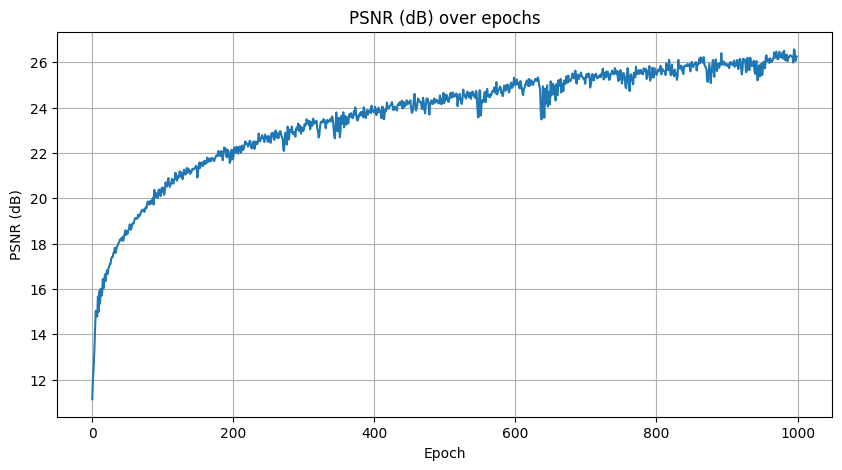

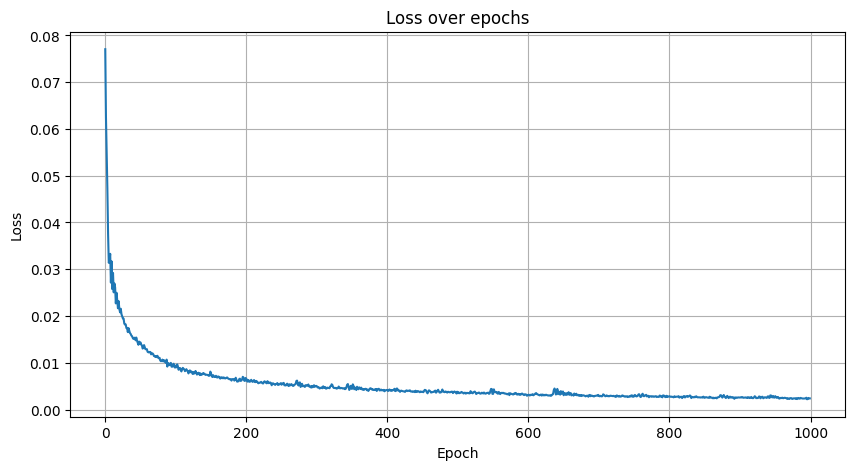

In [20]:
# # x dim is layer_width, y dim is L value

# The same parameters for each test in the 2x2 grid
img_path = "./fox.jpg"
img_size = 1000
epoch_count = 1000
batch_size = 10000
learning_rate = 1e-2

# Baseline Hyperparameters (top right)
layer_width = 256
L = 10
learning_rate = 1e-2
output_folder = "./tr/"
main(layer_width, L, img_path, img_size, epoch_count, batch_size, learning_rate, output_folder)

# Baseline Hyperparameters (bottom right)
layer_width = 256
L = 1
output_folder = "./br/"
main(layer_width, L, img_path, img_size, epoch_count, batch_size, learning_rate, output_folder)

# Baseline Hyperparameters (top left)
layer_width = 16
L = 10
output_folder = "./tl/"
main(layer_width, L, img_path, img_size, epoch_count, batch_size, learning_rate, output_folder)

# Baseline Hyperparameters (bottom left)
layer_width = 16
L = 1
output_folder = "./bl/"
main(layer_width, L, img_path, img_size, epoch_count, batch_size, learning_rate, output_folder)

# Training on custom
layer_width = 1024
img_path = "./berkeley.jpg"
L = 12
learning_rate = 1e-3
output_folder = "./custom/"
main(layer_width, L, img_path, img_size, epoch_count, batch_size, learning_rate, output_folder)
